<a href="https://colab.research.google.com/github/Watson15/GHIPrediction/blob/main/Copy_of_LSTMBCData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import random, os
import matplotlib.pyplot as plt
import pandas as pd
import glob
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Start of Load data and Preprocessing (can add more hashtags to change level of heading to have subheadings) (More hashes the "less important")

In [32]:
path = r'/content/drive/MyDrive/Colab Notebooks/CWEEDS_2020_BC'
csv_files = glob.glob(os.path.join(path, "*.csv"))
#print(csv_files)

In [33]:
import re
def getStationTimePeriodFromYears(csv_file):
  match = re.search(r'(\d{4})-(\d{4})', csv_file)
  if match:
    start_year = int(match.group(1))
    end_year = int(match.group(2))
    #print(start_year, end_year)  # Output: 2005 2017
    return (start_year, end_year)

In [34]:
# def get_stations_name_Lat_Long(csv_files):
#   DegreeLatitudes = []
#   DegreeLongitudes = []
#   DegreeLogitudesTimes2 = []
#   #FileName = []
#   Station = []
#   StationTimePeriodStart = []
#   StationTimePeriodEnd = []
#   for f in csv_files:
#       df = pd.read_csv(f, delimiter=',', nrows=2, on_bad_lines='skip')
#       #The ratio between longitude and latitude is 360:180; meaning for every 1 degree of latitude, there are 2 degrees of longitude, as there are 360 degrees of longitude and 180 degrees of latitude on Earth.
#       #Therefore when getting latitude data we multiply it by 2 to make it more accurate for distance calcs
#       TimePeriod = getStationTimePeriodFromYears(f)
#       StationTimePeriodStart.append(TimePeriod[0])
#       StationTimePeriodEnd.append(TimePeriod[1])
#       DegreeLatitudes.append(df['Degree latitude'][0])
#       DegreeLogitudesTimes2.append(df['Degree longitude'][0]*2)#Multiplied by 2 for training model but take away when analyzing and wanting to find real location for elevation
#       DegreeLongitudes.append(df['Degree longitude'][0])# Not Multiplied by 2 for analyzing and wanting to find real location for elevation
#       #FileName.append(f.split("\\")[-1])
#       Station.append(df['Climate station name'][0])
#   return pd.DataFrame({'Latitude': DegreeLatitudes, 'Longitude': DegreeLongitudes, 'LongitudeTimes2': DegreeLogitudesTimes2, "station": Station, "StartTime": StationTimePeriodStart, "EndTime": StationTimePeriodEnd})

In [35]:
# stationsName_lat_long_datadf = get_stations_name_Lat_Long(csv_files)
# lat_min = stationsName_lat_long_datadf["Latitude"].min()
# lat_max = stationsName_lat_long_datadf["Latitude"].max()
# long_min = stationsName_lat_long_datadf["Longitude"].min()
# long_max = stationsName_lat_long_datadf["Longitude"].max()

In [36]:
# def normalize_lat_lon(lat, lon):
#     norm_lat = (lat - lat_min) / (lat_max - lat_min)
#     norm_lon = (lon - long_min) / (long_max - long_min)
#     return norm_lat, norm_lon

In [37]:
# stationsName_lat_long_datadf[['norm_lat', 'norm_long']] = stationsName_lat_long_datadf.apply(lambda row: normalize_lat_lon(row['Latitude'], row['Longitude']), axis=1, result_type='expand')

In [38]:
file_path = '/content/drive/MyDrive/Colab Notebooks/stationsName_lat_long_data.csv'
stationsName_lat_long_datadf = pd.read_csv(file_path, delimiter=',', on_bad_lines='skip')

In [39]:
def plot_stations_matplotlib(center_latlon, neighbors_df, all_stations_df, figsize=(8, 6)):
    center_lat, center_lon = center_latlon

    # Create set of picked station names for easy lookup
    picked_names = set(neighbors_df['station'])

    plt.figure(figsize=figsize)

    # Plot unpicked stations (from all_stations_df, excluding the neighbors and center)
    for _, row in all_stations_df.iterrows():
        if (row['Latitude'], row['Longitude']) == tuple(center_latlon):
            continue
        if row['station'] not in picked_names:
            plt.scatter(row['Longitude'], row['Latitude'], color='gray', alpha=0.9, label='_nolegend_')
            #plt.text(row['Longitude'] + 0.002, row['Latitude'], row['station'], fontsize=8, color='gray')

    # Plot the selected neighbor stations
    plt.scatter(
        neighbors_df['Longitude'],
        neighbors_df['Latitude'],
        color='blue',
        label='Picked Neighbors'
    )
    # for _, row in neighbors_df.iterrows():
    #     plt.text(row['Longitude'] + 0.002, row['Latitude'], row['station'], fontsize=9)

    # Plot the target station
    plt.scatter(center_lon, center_lat, color='red', marker='*', s=150, label='Target Station')
    #plt.text(center_lon + 0.002, center_lat, 'Target', fontsize=10, fontweight='bold')

    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Target Station and Spatially Diverse Neighbors')
    plt.legend()
    plt.grid(True)
    plt.gca().set_aspect('equal', adjustable='datalim')
    plt.show()

In [40]:
# Euclidean distance function
def euclidean_distance(lat1, lon1, lat2, lon2):
    distance_vector = ((lat2 - lat1), lon2 - lon1)
    return ((np.sqrt((lat2 - lat1)**2) + (lon2 - lon1)**2), distance_vector)

# Function to find the K nearest stations (not returning nearest station given)
def find_k_nearest_stations(df, station_name, k):
    if station_name not in df['station'].values:
        return f"Station {station_name} not found in the dataset."

    # Get the coordinates of the given station
    station_coords = df[df['station'] == station_name][['Latitude', 'Longitude']].values[0]
    lat1, lon1 = station_coords

    # Calculate the distance from the given station to all other stations
    df['distance'] = df.apply(lambda row: euclidean_distance(lat1, lon1, row['Latitude'], row['Longitude']), axis=1)

    # station_coords = df[df['station'] == station_name][['norm_lat', 'norm_long']].values[0]
    # lat1, lon1 = station_coords

    # # Calculate the distance from the given station to all other stations
    # df['distance'] = df.apply(lambda row: euclidean_distance(lat1, lon1, row['norm_lat'], row['norm_long']), axis=1)

    # Sort the DataFrame by distance and get the K nearest stations
    #nearest_stations = df[df['station'] != station_name].sort_values(by='distance').head(k)
    nearest_stations = df[df['station'] != station_name].sort_values(by='distance', key=lambda x: x.apply(lambda y: y[0])).head(k)

    return nearest_stations[['station', 'norm_lat', 'norm_long', 'distance', 'StartTime', 'EndTime']]

In [41]:
def latlon_to_xy(lat, lon, lat0):
    """Simple equirectangular projection."""
    R = 6371  # radius in km
    x = R * np.radians(lon) * np.cos(np.radians(lat0))
    y = R * np.radians(lat)
    return x, y

def compute_angle(vec1, vec2):
    norm1 = np.linalg.norm(vec1)
    norm2 = np.linalg.norm(vec2)
    if norm1 == 0 or norm2 == 0:
        return 0  # Could return np.pi to maximize diversity if desired
    unit1 = vec1 / norm1
    unit2 = vec2 / norm2
    return np.arccos(np.clip(np.dot(unit1, unit2), -1.0, 1.0))

def makeDistanceTuple(distance, x, y):
  return (distance, (x,y))

def spatially_diverse_knn(df,station_name, k=3, candidate_pool=len(csv_files)):
  # spatially_diverse_knn_df
  #
  # This function selects the 'k' nearest stations to a given target station,
  # while ensuring that the selected neighbors are spatially diverse. Instead
  # of simply choosing the closest stations, it incorporates an angular diversity
  # criterion that selects stations spread out in different directions. This helps
  # avoid picking stations that are clustered in one region around the target.
  #
  # Parameters:
  #   - df: DataFrame containing station information (latitude, longitude, station_name)
  #   - center_latlon: Coordinates (latitude, longitude) of the target station
  #   - k: Number of neighbors to select (default is 3)
  #   - candidate_pool: Number of candidates to consider before selection (default is len(csv_files)=78)
  #
  # Returns:
  #   - A DataFrame with 'k' stations selected based on spatial diversity from the target
    # Exclude the center point if it exists in the set
    if station_name not in df['station'].values:
      return f"Station {station_name} not found in the dataset."

    center_latlon = df[df['station'] == station_name][['Latitude', 'Longitude']].values[0]
    mask = ~((df['Latitude'] == center_latlon[0]) & (df['Longitude'] == center_latlon[1]))
    df_filtered = df[mask].copy()
    #df_filtered['distance_vector'] = [(0.0, (0.0, 0.0))] * len(df_filtered)  # Initialize with default values

    # Convert to x/y coords
    lat0 = center_latlon[0]
    df_filtered['x'], df_filtered['y'] = latlon_to_xy(df_filtered['Latitude'], df_filtered['Longitude'], lat0)
    center_x, center_y = latlon_to_xy(center_latlon[0], center_latlon[1], lat0)
    center_xy = np.array([center_x, center_y])

    # Compute distances
    df_filtered['distance'] = np.linalg.norm(df_filtered[['x', 'y']].values - center_xy, axis=1)
    df_sorted = df_filtered.sort_values('distance').head(candidate_pool)
    df_sorted['distance'] = df_sorted.apply(lambda row: makeDistanceTuple(row['distance'], row['x'], row['y']), axis=1)
    selected_rows = []
    selected_xy = []

    for idx, row in df_sorted.iterrows():
        cand_xy = np.array([row['distance'][1][0], row['distance'][1][1]])
        if len(selected_xy) == 0: #gets closest station
            selected_rows.append(row)
            selected_xy.append(cand_xy)
        else:
            angles = [compute_angle(cand_xy - center_xy, s - center_xy) for s in selected_xy]
            min_angle = min(angles)
            if min_angle > np.radians(45) or len(selected_xy) < k // 2:
                selected_rows.append(row)
                selected_xy.append(cand_xy)
        if len(selected_rows) == k:
            break

    # selectedStations = pd.DataFrame(selected_rows).drop(columns=['x', 'y']).reset_index(drop=True)
    # selectedStations.rename(columns= {'distance_vector': 'distance'}, inplace=True)
    return pd.DataFrame(selected_rows).drop(columns=['x', 'y']).reset_index(drop=True), center_latlon

In [42]:
def find_nearest_station_given_long_lat(df,Longitude, Latitude):
    # Find the station with the smallest Euclidean distance to the given coordinates
    df['distance'] = df.apply(lambda row: euclidean_distance(Latitude, Longitude, row['Latitude'], row['Longitude']), axis=1)
    nearest_station = df.sort_values(by='distance', key=lambda x: x.apply(lambda y: y[0])).head(1)
    return nearest_station[['station', 'Latitude', 'Longitude', 'distance', 'StartTime', 'EndTime']]

    #To get station name print(str(wanted_station.station.iloc[0]))

In [43]:
def find_nearest_station_given_normed_long_lat(df,Longitude_Normed, Latitude_Normed):
    # Find the station with the smallest Euclidean distance to the given coordinates
    df['distance'] = df.apply(lambda row: euclidean_distance(Longitude_Normed, Latitude_Normed, row['norm_lat'], row['norm_long']), axis=1)
    nearest_station = df.sort_values(by='distance', key=lambda x: x.apply(lambda y: y[0])).head(1)
    return nearest_station[['station', 'norm_lat', 'norm_long', 'distance', 'StartTime', 'EndTime']]

    #To get station name print(str(wanted_station.station.iloc[0]))

In [44]:
def modify_nearest_stations(nearest_stations):
    modified_nearest_stations = []
    for station in nearest_stations['station']:
        modified_station = station.replace(" ", "-")
        modified_nearest_stations.append(modified_station)
    return modified_nearest_stations

In [45]:
def find_stations_csv(stations, csvs):
    station_order = []
    nearest_stations_csvs = []
    for station in stations:
        for csv in csvs:
            if station.lower() in csv.lower():
                nearest_stations_csvs.append(csv)
                print(f"Station {station} found in {csv}")
                station_order.append(station)
                break
    return nearest_stations_csvs, station_order

In [46]:
def adjustWindDirection(wind_direction_degress, theta_relative):
#Adjusts auxillary stations wind direction to be relative to the wanted stations position
  # Adjust the wind direction by subtracting the relative angle
  adjusted_wind_direction = wind_direction_degress - theta_relative
  # Normalize to 0-360 degrees
  adjusted_wind_direction = (adjusted_wind_direction + 360) % 360
  return adjusted_wind_direction

In [47]:
def cyclicalEncoding(data, cycleLength):
  newDatasin = np.sin(2 * np.pi * (data - 1) / cycleLength)  # Sine encoding for hours (adjust for 0-23)
  newDatacos = np.cos(2 * np.pi * (data - 1) / cycleLength)  # Cosine encoding for hours (adjust for 0-23)
  return newDatasin, newDatacos

In [48]:
usecols = [
    'Year Month Day Hour (YYYYMMDDHH)',
    'Global horizontal irradiance / kJ/m2',
    'Direct normal irradiance / kJ/m2',
    'Diffuse horizontal irradiance / kJ/m2',
    'Wind direction / 0-359 degrees',
    'Wind speed / 0.1 m/s'
]

dtype = {
    'Year Month Day Hour (YYYYMMDDHH)': str,  # Read as string initially to handle errors
    'Global horizontal irradiance / kJ/m2': str,
    'Direct normal irradiance / kJ/m2': str,
    'Diffuse horizontal irradiance / kJ/m2': str,
    'Wind direction / 0-359 degrees': str,
    'Wind speed / 0.1 m/s': str
}

In [49]:
def get_nearest_stations_data(nearest_stations_csvs, min_start_year, max_end_year, wantedStationCSV=False, RelativeAnglesDegrees=[(0,0)]):
    dfs = []
    i = 0
    meanGHI = 0
    stdGHI = 0
    for f in nearest_stations_csvs:
      # Read the CSV file with specified columns and data types
      df = pd.read_csv(f, delimiter=',', skiprows=2, index_col=False, usecols=usecols, dtype=dtype, on_bad_lines='skip')
      # Convert columns to numeric, coercing errors to NaN
      for col in usecols:
          if(col == 'Year Month Day Hour (YYYYMMDDHH)'):
              #keep as string
              df['Year Month Day Hour (YYYYMMDDHH)'] = df[col].astype(int)
              df = df[df['Year Month Day Hour (YYYYMMDDHH)']>min_start_year]
              df = df[df['Year Month Day Hour (YYYYMMDDHH)']<=max_end_year]#Data is between min_start_year and max_end_year to accomidate files that dont have the same amount of data

              if(wantedStationCSV): #get month and hour for just wanted station
                  df['Year Month Day Hour (YYYYMMDDHH)'] = df['Year Month Day Hour (YYYYMMDDHH)'].astype(str)
                  # Get month (1-12)
                  df['Month'] = df['Year Month Day Hour (YYYYMMDDHH)'].str[4:6].astype(int)
                  # Get hour (1-24)
                  df['Hour'] = df['Year Month Day Hour (YYYYMMDDHH)'].str[8:10].astype(int)
                  # Normalize hour so cyclic (0-23)
                  df['Hour_sin'], df['Hour_cos'] = cyclicalEncoding(df['Hour'], 24)# Sine and Cosine encoding for hours (adjust for 0-23)
                  # df['Hour_sin'] = np.sin(2 * np.pi * (df['Hour'] - 1) / 24)
                  # df['Hour_cos'] = np.cos(2 * np.pi * (df['Hour'] - 1) / 24)  # Cosine encoding for hours (adjust for 0-23)
                  # Normalize month so cyclic (0-11))
                  df['Month_sin'], df['Month_cos'] = cyclicalEncoding(df['Month'], 12)# Sine and Cosine encoding for months
                  # df['Month_sin'] = np.sin(2 * np.pi *  (df['Month']-1)/ 12)  # Sine encoding for months
                  # df['Month_cos'] = np.cos(2 * np.pi *  (df['Month']-1) / 12)  # Cosine encoding for months
                  df = df.drop(columns=['Month'], axis=1)
                  df = df.drop(columns=['Hour'], axis=1)

              df = df.drop(columns=[col], axis=1)
              continue

          if(col=='Wind direction / 0-359 degrees'):
              df[col] = pd.to_numeric(df[col], errors='coerce').replace(99, np.nan)
              if(not wantedStationCSV):
                df[col] = df[col].apply(lambda x: adjustWindDirection(x, RelativeAnglesDegrees[i]))
                #When wind is pointed towards the wanted station it has a new angle of 0 degrees and when pointed directly away from it it has a 180 degrees value now
              radians = np.deg2rad(df[col])
              df['wind_dir_sin'] = np.sin(radians)
              df['wind_dir_cos'] = np.cos(radians)
              df = df.drop(columns=[col], axis=1)
              continue

          if(col == 'Wind speed / 0.1 m/s'):
              df[col] = pd.to_numeric(df[col], errors='coerce').replace(99, np.nan)
              mean = df[col].mean()
              std = df[col].std()
              df[col] = (df[col] - mean) / std
              continue

          if (col == 'Global horizontal irradiance / kJ/m2' or col == 'Direct normal irradiance / kJ/m2' or col == 'Diffuse horizontal irradiance / kJ/m2'):
              df[col] = pd.to_numeric(df[col], errors='coerce').replace(9999, np.nan)
              mean = df[col].mean()
              std = df[col].std()
              df[col] = (df[col] - mean) / std #can denormalize output
              if (col == 'Global horizontal irradiance / kJ/m2'):
                meanGHI = mean
                stdGHI = std #for denormalizing
              continue
          df[col] = pd.to_numeric(df[col], errors='coerce')
      df.fillna(0, inplace=True)
      dfs.append(df)
      i+=1
      #print(df.columns)
    return dfs, meanGHI, stdGHI

In [50]:
def chunk(df, interval = 25):
    results = []
    for i in range(0, len(df)-interval, 1):
        chunk = df[i:i+interval]
        results.append(chunk)
    results = np.array(results)
    return results

In [51]:
def get_chunked_tensors(nearest_stations, dfs, interval):
  chunked_tensors = []
  rows = 0
  station_order = []
  for index, station in nearest_stations.iterrows():
    distanceVector = station.iloc[3][1]
    chunked_df = chunk(dfs[rows], interval=interval)
    rows+=1
    chunkedTensor = torch.tensor(chunked_df).to(torch.float32)
    chunked_tensors.append(chunkedTensor)
    station_order.append(station)
  return chunked_tensors, station_order

In [52]:
def getMaxStartMinEndYearComplete(max_start_year, min_end_year):
  maxStartYear, minEndYear = str(max_start_year), str(min_end_year)
  #print(max_start_year, min_end_year)
  maxStartYear = maxStartYear+"010100"
  minEndYear = minEndYear+"123124"
  maxStartYear = int(maxStartYear)
  minEndYear = int(minEndYear)
  return maxStartYear, minEndYear

In [53]:
def getAllKAuxillaryStationsReadyByWantedStationName(stationsName_lat_long_datadf, nearest_stations, k, min_start_year, max_end_year, RelativeAnglesDegrees):
  #doing all thats needed to get Auxillary stations data ready and in chunked tensors and in order chunked
  modified_nearest_stations = modify_nearest_stations(nearest_stations)
  nearest_stations_csvs, station_order = find_stations_csv(modified_nearest_stations, csv_files)
  nearest_stations_data_dfs, _, _ = get_nearest_stations_data(nearest_stations_csvs, min_start_year, max_end_year, False, RelativeAnglesDegrees)

  for i in range(k):
    nearest_stations_data_dfs[i]["distanceX"] = [nearest_stations['distance'].values[i][1][0]]*len(nearest_stations_data_dfs[i])
    nearest_stations_data_dfs[i]["distanceY"] = [nearest_stations['distance'].values[i][1][1]]*len(nearest_stations_data_dfs[i])
    #print(nearest_stations_data_dfs[i].head())
    #print(nearest_stations_data_dfs[i].columns)
  aux_chunked_tensors, aux_chunked_station_order = get_chunked_tensors(nearest_stations, nearest_stations_data_dfs, 25)
  return aux_chunked_tensors, aux_chunked_station_order

In [54]:
def getAllReadyForStationByLatAndLongAndK(stationsName_lat_long_datadf, lat, long, k):
  #doing everything needed to get wanted stations data ready and in chunked tensors as well as get wanted station and its name
  wanted_station = find_nearest_station_given_long_lat(stationsName_lat_long_datadf, lat, long)
  max_start_year = wanted_station["StartTime"].values[0]
  min_end_year = wanted_station["EndTime"].values[0]

  wanted_station.at[wanted_station.index[0], "distance"] = (0.0, (0.0, 0.0))
  wanted_station_modified = modify_nearest_stations({"station": wanted_station["station"]})
  wanted_station_csv, _ = find_stations_csv(wanted_station_modified, csv_files)

  nearest_stations, target_point = spatially_diverse_knn(stationsName_lat_long_datadf, wanted_station["station"].values[0], k)
  plot_stations_matplotlib(target_point, nearest_stations, stationsName_lat_long_datadf)
  max_start_year, min_end_year = max(max_start_year, *nearest_stations["StartTime"].values), min(min_end_year, *nearest_stations["EndTime"].values)
  max_start_year, min_end_year = getMaxStartMinEndYearComplete(max_start_year, min_end_year)

  RelativeAnglesDegrees = []
  for distanceVector in nearest_stations["distance"].values:
    Relative_Angle_Radians = np.arctan2(distanceVector[1][1], distanceVector[1][0])#Relative Distance Vector y and Distance Vector x
    Relative_Angle_Degrees = np.degrees(Relative_Angle_Radians)
    if Relative_Angle_Degrees < 0:
      Relative_Angle_Degrees += 360
    RelativeAnglesDegrees.append(Relative_Angle_Degrees)

  aux_chunked_tensors, aux_chunked_station_order = getAllKAuxillaryStationsReadyByWantedStationName(stationsName_lat_long_datadf, nearest_stations, k, max_start_year, min_end_year, RelativeAnglesDegrees)

  wanted_station_data_dfs, meanGHI, stdGHI = get_nearest_stations_data(wanted_station_csv, max_start_year, min_end_year,wantedStationCSV=True)
  #print(wanted_station_data_dfs[0].head())
  wanted_chunked_tensors, _ = get_chunked_tensors(wanted_station, wanted_station_data_dfs, 25)

  return wanted_chunked_tensors, wanted_station["station"].values[0], aux_chunked_tensors, aux_chunked_station_order, meanGHI, stdGHI

In [55]:
def getAllReadyForStationByLatAndLongAndKSplitTestAndTrain(stationsName_lat_long_datadf, lat, long, k):
  #doing everything needed to get wanted stations data ready and in chunked tensors as well as get wanted station and its name
  wanted_station = find_nearest_station_given_long_lat(stationsName_lat_long_datadf, lat, long)
  max_start_year = wanted_station["StartTime"].values[0]
  min_end_year = wanted_station["EndTime"].values[0]

  wanted_station.at[wanted_station.index[0], "distance"] = (0.0, (0.0, 0.0))
  wanted_station_modified = modify_nearest_stations({"station": wanted_station["station"]})
  wanted_station_csv, _ = find_stations_csv(wanted_station_modified, csv_files)

  nearest_stations, target_point = spatially_diverse_knn(stationsName_lat_long_datadf, wanted_station["station"].values[0], k)
  plot_stations_matplotlib(target_point, nearest_stations, stationsName_lat_long_datadf)
  max_start_year, min_end_year = max(max_start_year, *nearest_stations["StartTime"].values), min(min_end_year, *nearest_stations["EndTime"].values)#Get earliest year that all start at (max_start_year) and latest year all go until (min_end_year)
  train_max_start_year, train_min_end_year = getMaxStartMinEndYearComplete(max_start_year, min_end_year-2)
  test_max_start_year, test_min_end_year = getMaxStartMinEndYearComplete(min_end_year-1, min_end_year)

  print(max_start_year,min_end_year)
  print(train_max_start_year, train_min_end_year)
  print(test_max_start_year, test_min_end_year)

  RelativeAnglesDegrees = []
  for distanceVector in nearest_stations["distance"].values:
    Relative_Angle_Radians = np.arctan2(distanceVector[1][1], distanceVector[1][0])#Relative Distance Vector y and Distance Vector x
    Relative_Angle_Degrees = np.degrees(Relative_Angle_Radians)
    if Relative_Angle_Degrees < 0:
      Relative_Angle_Degrees += 360
    RelativeAnglesDegrees.append(Relative_Angle_Degrees)

  trainSet_aux_chunked_tensors, trainSet_aux_chunked_station_order = getAllKAuxillaryStationsReadyByWantedStationName(stationsName_lat_long_datadf, nearest_stations, k, train_max_start_year, train_min_end_year, RelativeAnglesDegrees)
  testSet_aux_chunked_tensors, testSet_aux_chunked_station_order = getAllKAuxillaryStationsReadyByWantedStationName(stationsName_lat_long_datadf, nearest_stations, k, test_max_start_year, test_min_end_year, RelativeAnglesDegrees)

  trainSet_wanted_station_data_dfs = get_nearest_stations_data(wanted_station_csv, train_max_start_year, train_min_end_year,wantedStationCSV=True)
  testSet_wanted_station_data_dfs = get_nearest_stations_data(wanted_station_csv, test_max_start_year, test_min_end_year,wantedStationCSV=True)
  #print(wanted_station_data_dfs[0].head())

  trainSet_wanted_chunked_tensors, _ = get_chunked_tensors(wanted_station, trainSet_wanted_station_data_dfs, 25)
  testSet_wanted_chunked_tensors, _ = get_chunked_tensors(wanted_station, testSet_wanted_station_data_dfs, 25)

  return trainSet_wanted_chunked_tensors, testSet_wanted_chunked_tensors, wanted_station["station"].values[0], trainSet_aux_chunked_tensors, testSet_aux_chunked_tensors, trainSet_aux_chunked_station_order, testSet_aux_chunked_station_order

In [56]:
def denormalizeHourOrMonth(anglesin, anglecos, cycleLength):
  angle = np.arctan2(anglesin, anglecos)
  cycleBeforeModulo = (angle / (2 * np.pi)) * cycleLength + 1
  return (cycleBeforeModulo % cycleLength)

In [57]:
def combineDataForMultipleStations():
  #will look into getting auxillary stations by not k nearest but instead giving a list of latitudes and longitudes to fins nearest stations to those to use as auxillary stations
  return

end of Preprocessing
## Dataset Creation and Model Architecture

In [58]:
class GHIDataset(Dataset):
    def __init__(self, chunked_data, device='cuda'):
        super(GHIDataset, self).__init__()
        self.chunked_data = chunked_data.to(device) #chunked data needs to be passed in as a tensor
        self.device = device

    def __len__(self):
        return len(self.chunked_data)

    def __getitem__(self, i):
        element = self.chunked_data[i] #need to break down to zeroth element of list and first element of that is GHI of that which is the target
        # inputs = []
        # for el in element:
        #   inputs.append(el[0:-1])
        #print(element.shape)
        return element[0:-1], element[-1,0] #ensure first station in dataset is the one we are wanting to predict

In [59]:
class Main_LSTM(nn.Module):
    def __init__(self, dropout=0.0):
        """
        input_dim: Number of features per time step (here, 5)
        hidden_dim: Number of hidden units in the LSTM
        num_layers: Number of stacked LSTM layers
        dropout: Dropout probability (applied between LSTM layers if num_layers > 1)
        """
        super(Main_LSTM, self).__init__()
        self.Stationlstm = nn.LSTM(34, 128, 3,
                            batch_first=True, dropout=dropout)
        self.Auxlstm = nn.LSTM(8, 8, 2,
                            batch_first=True, dropout=dropout)#may need to change 16 back to 8
        # A fully-connected layer to map the LSTM output to a single GHI prediction
        self.station_fc = nn.Linear(128, 1)

    def forward(self, x):
        # x shape: (batch_size, sequence_length, input_dim)
        # LSTM returns output for every time step, and the final hidden and cell states.

        #torch.Size([32, 24, 64])
        main_station_data = x[:, :, :10]  # First 10 features are for main station
        aux_station_data = x[:, :, 10:]  # Remaining features are for auxiliary stations
        aux_lstm_outs = []
        #other idea: range start at 10 go to 34 add 8 each time as 3 auxillaries
        for i in range(0, 24, 8): #range start at 0 go to 24 add 8 each time as 3 auxillary stations
          lstm_out, _ = self.Auxlstm(aux_station_data[:, :, i:i+8])
          aux_lstm_outs.append(lstm_out)
        concat = torch.cat(([main_station_data]+aux_lstm_outs), 2)
        #print(concat.shape)
        lstm_out, (h_n, c_n) = self.Stationlstm(concat)
        # Use the output from the last time step as a summary of the sequence
        # lstm_out[:, -1, :] has shape (batch_size, hidden_dim)
        #print("Main: ", lstm_out.shape)
        final_feature = lstm_out[:, -1, :] #Not sure if this WORKSSSS (Right size?)
        #torch.Size([32, 64])

        # Pass through the fully-connected layer to produce a single output
        ghi_pred = self.station_fc(final_feature)  # shape: (batch_size, 1)
        return ghi_pred

In [60]:
# Check if GPU is available and set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


End of Model architecture

##Start of Splitting data into test and train set preproccessing

In [ ]:
#Maybe make this a dictionary instead so dont have so many variables
trainSet_wanted_chunked_tensors, testSet_wanted_chunked_tensors, wanted_station_name, trainSet_aux_chunked_tensors, testSet_aux_chunked_tensors, trainSet_aux_chunked_station_order, testSet_aux_chunked_station_order = getAllReadyForStationByLatAndLongAndKSplitTestAndTrain(stationsName_lat_long_datadf.copy(), -263.5, 54.5, 3)

Station CUMSHEWA-ISLAND found in /content/drive/MyDrive/Colab Notebooks/CWEEDS_2020_BC/CAN_BC_CUMSHEWA-ISLAND_1062251_CWEEDS2011_1998-2017.csv
1998 2017
1998010100 2015123124
2016010100 2017123124
Station SANDSPIT found in /content/drive/MyDrive/Colab Notebooks/CWEEDS_2020_BC/CAN_BC_SANDSPIT_1057052_CWEEDS2011_1998-2017.csv
Station KINDAKUN-ROCKS-(AUT) found in /content/drive/MyDrive/Colab Notebooks/CWEEDS_2020_BC/CAN_BC_KINDAKUN-ROCKS-(AUT)_1054222_CWEEDS2011_1998-2017.csv
Station BONILLA-ISLAND-(AUT) found in /content/drive/MyDrive/Colab Notebooks/CWEEDS_2020_BC/CAN_BC_BONILLA-ISLAND-(AUT)_1060R0K_CWEEDS2011_1998-2017.csv
Station SANDSPIT found in /content/drive/MyDrive/Colab Notebooks/CWEEDS_2020_BC/CAN_BC_SANDSPIT_1057052_CWEEDS2011_1998-2017.csv
Station KINDAKUN-ROCKS-(AUT) found in /content/drive/MyDrive/Colab Notebooks/CWEEDS_2020_BC/CAN_BC_KINDAKUN-ROCKS-(AUT)_1054222_CWEEDS2011_1998-2017.csv
Station BONILLA-ISLAND-(AUT) found in /content/drive/MyDrive/Colab Notebooks/CWEEDS_20

In [ ]:
combined_train_chunked_data_tensor = torch.cat(trainSet_wanted_chunked_tensors + trainSet_aux_chunked_tensors, dim=2)
combined_test_chunked_data_tensor = torch.cat(testSet_wanted_chunked_tensors + testSet_aux_chunked_tensors, dim=2)
print(combined_train_chunked_data_tensor.shape)
print(combined_test_chunked_data_tensor.shape)

In [ ]:
dataset = GHIDataset(combined_train_chunked_data_tensor, device=device)#For training
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [ ]:
dataset_test = GHIDataset(combined_test_chunked_data_tensor, device=device)
train_loader_test = DataLoader(dataset_test, batch_size=32, shuffle=True)

Done Splitting data preproccessing
##Non Splitting data preproccessing

Station ROSE-SPIT-(AUT) found in /content/drive/MyDrive/Colab Notebooks/CWEEDS_2020_BC/CAN_BC_ROSE-SPIT-(AUT)_1056869_CWEEDS2011_1998-2017.csv


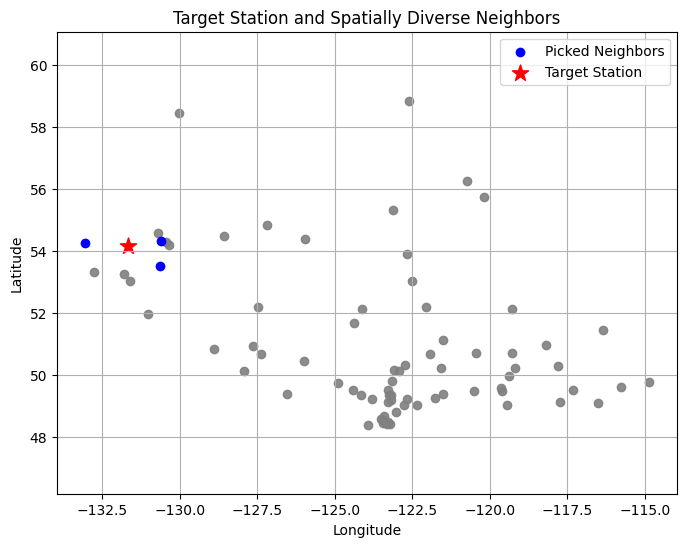

Station LUCY-ISLAND-LIGHTSTATION found in /content/drive/MyDrive/Colab Notebooks/CWEEDS_2020_BC/CAN_BC_LUCY-ISLAND-LIGHTSTATION_1064728_CWEEDS2011_1999-2017.csv
Station LANGARA-ISLAND-RCS found in /content/drive/MyDrive/Colab Notebooks/CWEEDS_2020_BC/CAN_BC_LANGARA-ISLAND-RCS_1054503_CWEEDS2011_1998-2016.csv
Station BONILLA-ISLAND-(AUT) found in /content/drive/MyDrive/Colab Notebooks/CWEEDS_2020_BC/CAN_BC_BONILLA-ISLAND-(AUT)_1060R0K_CWEEDS2011_1998-2017.csv


In [61]:
wanted_chunked_tensors, wanted_station_name, aux_chunked_tensors, aux_chunked_station_order, meanGHI1, stdGHI1 = getAllReadyForStationByLatAndLongAndK(stationsName_lat_long_datadf.copy(), -131.75, 54.5, 3)

In [62]:
wanted_chunked_tensors[0].shape

torch.Size([157775, 25, 10])

In [63]:
combined_chunked_data_tensor1 = torch.cat(wanted_chunked_tensors + aux_chunked_tensors, dim=2)

Station WHISTLER---NESTERS found in /content/drive/MyDrive/Colab Notebooks/CWEEDS_2020_BC/CAN_BC_WHISTLER---NESTERS_1100875_CWEEDS2011_2005-2017.csv


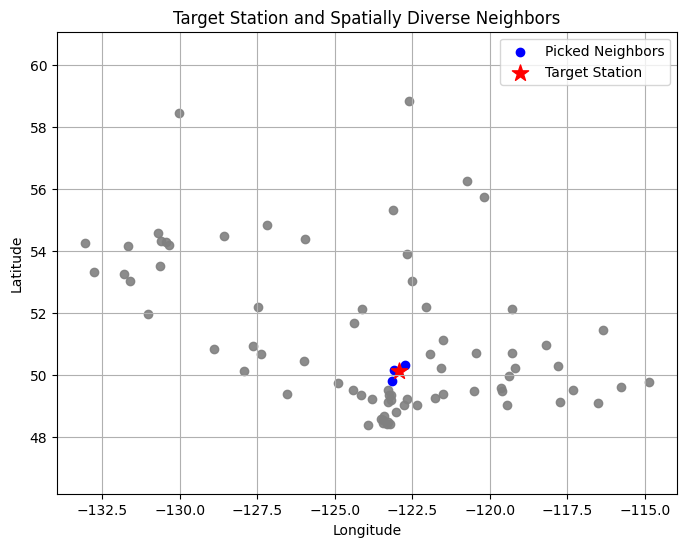

Station CALLAGHAN-VALLEY found in /content/drive/MyDrive/Colab Notebooks/CWEEDS_2020_BC/CAN_BC_CALLAGHAN-VALLEY_1101300_CWEEDS2011_2005-2017.csv
Station PEMBERTON-AIRPORT-CS found in /content/drive/MyDrive/Colab Notebooks/CWEEDS_2020_BC/CAN_BC_PEMBERTON-AIRPORT-CS_1086082_CWEEDS2011_1998-2017.csv
Station SQUAMISH-AIRPORT found in /content/drive/MyDrive/Colab Notebooks/CWEEDS_2020_BC/CAN_BC_SQUAMISH-AIRPORT_10476F0_CWEEDS2011_1998-2017.csv


In [64]:
wanted_chunked_tensors, wanted_station_name, aux_chunked_tensors, aux_chunked_station_order, meanGHI2, stdGHI2 = getAllReadyForStationByLatAndLongAndK(stationsName_lat_long_datadf.copy(), -123, 50,3)

In [65]:
combined_chunked_data_tensor2 = torch.cat(wanted_chunked_tensors + aux_chunked_tensors, dim=2)

Station ESQUIMALT-HARBOUR found in /content/drive/MyDrive/Colab Notebooks/CWEEDS_2020_BC/CAN_BC_ESQUIMALT-HARBOUR_1012710_CWEEDS2011_1998-2017.csv


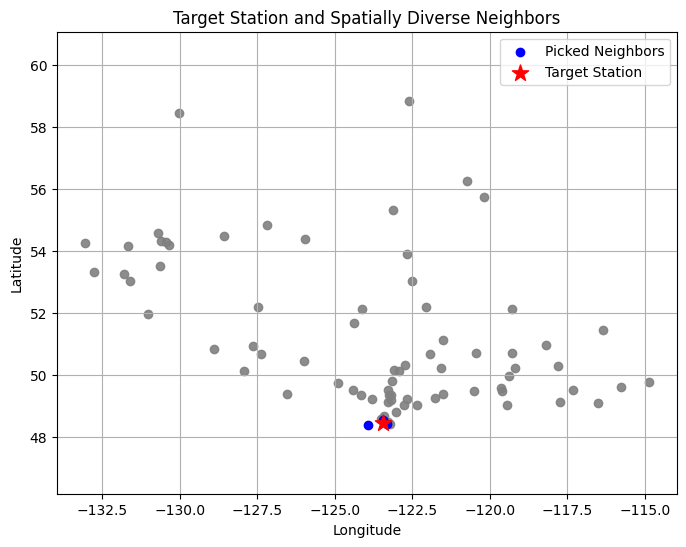

Station VICTORIA-GONZALES-CS found in /content/drive/MyDrive/Colab Notebooks/CWEEDS_2020_BC/CAN_BC_VICTORIA-GONZALES-CS_1018611_CWEEDS2011_1998-2017.csv
Station VICTORIA-HARTLAND-CS found in /content/drive/MyDrive/Colab Notebooks/CWEEDS_2020_BC/CAN_BC_VICTORIA-HARTLAND-CS_1018FJ5_CWEEDS2011_1998-2011.csv
Station SHERINGHAM-POINT found in /content/drive/MyDrive/Colab Notebooks/CWEEDS_2020_BC/CAN_BC_SHERINGHAM-POINT_1017254_CWEEDS2011_1998-2017.csv


In [66]:
wanted_chunked_tensors, wanted_station_name, aux_chunked_tensors, aux_chunked_station_order, meanGHI3, stdGHI3 = getAllReadyForStationByLatAndLongAndK(stationsName_lat_long_datadf.copy(), -123.5, 48,3)
combined_chunked_data_tensor3 = torch.cat(wanted_chunked_tensors + aux_chunked_tensors, dim=2)

Station FORT-NELSON-A found in /content/drive/MyDrive/Colab Notebooks/CWEEDS_2020_BC/CAN_BC_FORT-NELSON-A_1192946_CWEEDS2011_2005-2017.csv


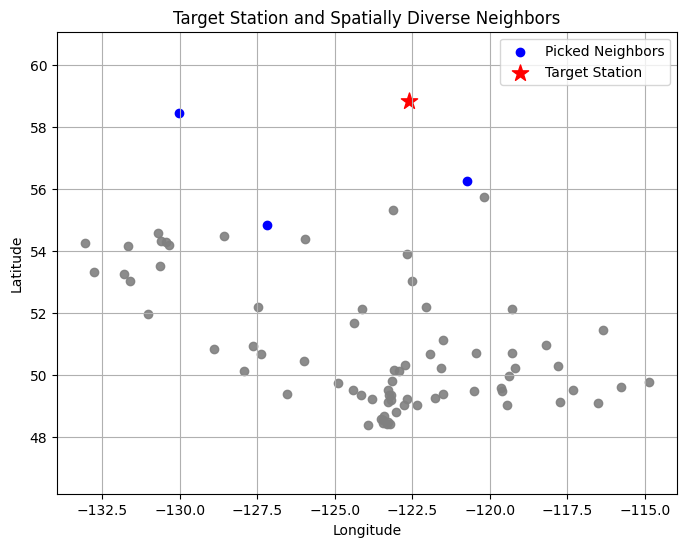

Station FORT-ST-JOHN-A found in /content/drive/MyDrive/Colab Notebooks/CWEEDS_2020_BC/CAN_BC_FORT-ST-JOHN-A_1183001_CWEEDS2011_1998-2017.csv
Station DEASE-LAKE-(AUT) found in /content/drive/MyDrive/Colab Notebooks/CWEEDS_2020_BC/CAN_BC_DEASE-LAKE-(AUT)_119BLM0_CWEEDS2011_2005-2017.csv
Station SMITHERS found in /content/drive/MyDrive/Colab Notebooks/CWEEDS_2020_BC/CAN_BC_SMITHERS_1077499_CWEEDS2011_1998-2017.csv


In [67]:
wanted_chunked_tensors, wanted_station_name, aux_chunked_tensors, aux_chunked_station_order, meanGHI4, stdGHI4 = getAllReadyForStationByLatAndLongAndK(stationsName_lat_long_datadf.copy(), -122.5, 60,3)
combined_chunked_data_tensor4 = torch.cat(wanted_chunked_tensors + aux_chunked_tensors, dim=2)

Station HERBERT-ISLAND-(AUT) found in /content/drive/MyDrive/Colab Notebooks/CWEEDS_2020_BC/CAN_BC_HERBERT-ISLAND-(AUT)_1063461_CWEEDS2011_1998-2017.csv


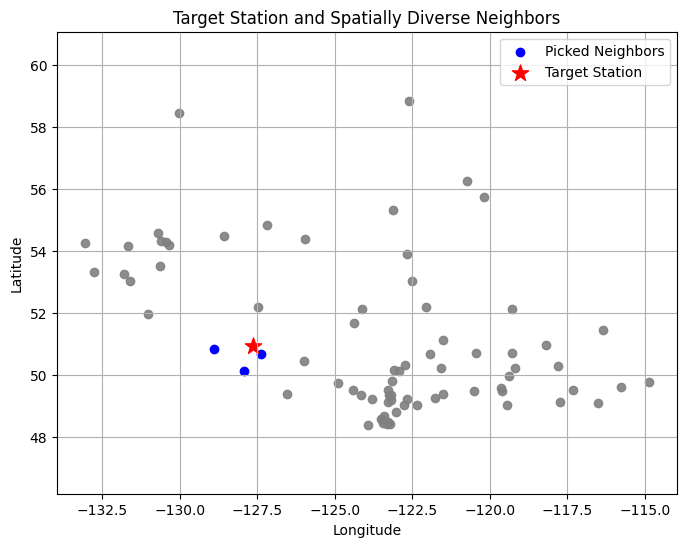

Station PORT-HARDY-A found in /content/drive/MyDrive/Colab Notebooks/CWEEDS_2020_BC/CAN_BC_PORT-HARDY-A_1026271_CWEEDS2011_1998-2017.csv
Station SARTINE-ISLAND-(AUT) found in /content/drive/MyDrive/Colab Notebooks/CWEEDS_2020_BC/CAN_BC_SARTINE-ISLAND-(AUT)_1037090_CWEEDS2011_1998-2017.csv
Station SOLANDER-ISLAND-(AUT) found in /content/drive/MyDrive/Colab Notebooks/CWEEDS_2020_BC/CAN_BC_SOLANDER-ISLAND-(AUT)_1037553_CWEEDS2011_1999-2017.csv


In [68]:
wanted_chunked_tensors, wanted_station_name, aux_chunked_tensors, aux_chunked_station_order, meanGHI5, stdGHI5 = getAllReadyForStationByLatAndLongAndK(stationsName_lat_long_datadf.copy(), -127.75, 51,3)
combined_chunked_data_tensor5 = torch.cat(wanted_chunked_tensors + aux_chunked_tensors, dim=2)

In [69]:
combined_chunked_data_tensor = torch.cat([combined_chunked_data_tensor1, combined_chunked_data_tensor2, combined_chunked_data_tensor3, combined_chunked_data_tensor4, combined_chunked_data_tensor5], dim=0)

In [70]:
combined_chunked_data_tensor.shape

torch.Size([674851, 25, 34])

In [71]:
#Deleting all tensors and data no longer needed to save space on RAM
del wanted_chunked_tensors, wanted_station_name, aux_chunked_tensors, aux_chunked_station_order
del combined_chunked_data_tensor1, combined_chunked_data_tensor2, combined_chunked_data_tensor3, combined_chunked_data_tensor4, combined_chunked_data_tensor5

Data loaded
##Create Model

In [72]:
#combined_chunked_data_tensor = torch.cat(wanted_chunked_tensors + aux_chunked_tensors, dim=2)

In [73]:
#dataset = GHIDataset(combined_chunked_data_tensor, device=device)
dataset = GHIDataset(combined_chunked_data_tensor, device=device)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [74]:
mainModel = Main_LSTM().to(device)
mainModel = torch.compile(mainModel)
#mainModel = Main_LSTM()
criterion = nn.MSELoss()  # Mean Squared Error is common for regression tasks
optimizer_main = optim.Adam(mainModel.parameters(), lr=0.001)

In [75]:
#mainModel.load_state_dict(torch.load(r'/content/drive/MyDrive/Colab Notebooks/modelMain8_WithTime_5Stations_k_3_MoreLayers.pth'))

Model Created
##train Model

In [ ]:
num_epochs = 65
loss_per_epoch = []
for epoch in tqdm(range(num_epochs)):
  mainModel.train()
  #epoch_lossList = []
  epoch_loss = 0.0
  for inputs, target in train_loader:
      # Move data to the same device as the model
      #inputs = inputs.to(device)      # shape: (batch_size, 24, 6)
      #target = target.to(device)      # shape: (batch_size,)

      optimizer_main.zero_grad()

      # Forward pass: predict GHI
      output = mainModel(inputs)          # shape: (batch_size, 1)

      # Compute loss (unsqueeze target if necessary to match output shape)
      loss = criterion(output, target.unsqueeze(1))

      # Backward pass and optimization
      loss.backward()
      optimizer_main.step()
      epoch_loss += loss.item() * inputs.size(0)

      #epoch_lossList.append(loss.item())

  epoch_loss /= len(dataset)
  loss_per_epoch.append(epoch_loss)
  print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.8f}")

  2%|▏         | 1/50 [02:45<2:15:25, 165.83s/it]

Epoch 1/50, Loss: 0.06139585


  4%|▍         | 2/50 [05:25<2:09:35, 161.98s/it]

Epoch 2/50, Loss: 0.05460892


  6%|▌         | 3/50 [08:05<2:06:16, 161.20s/it]

Epoch 3/50, Loss: 0.05214896


  8%|▊         | 4/50 [10:45<2:03:14, 160.75s/it]

Epoch 4/50, Loss: 0.05058907


 10%|█         | 5/50 [13:25<2:00:23, 160.51s/it]

Epoch 5/50, Loss: 0.04929718


 12%|█▏        | 6/50 [16:05<1:57:39, 160.45s/it]

Epoch 6/50, Loss: 0.04820930


 14%|█▍        | 7/50 [18:45<1:54:50, 160.25s/it]

Epoch 7/50, Loss: 0.04711741


 16%|█▌        | 8/50 [21:27<1:52:24, 160.59s/it]

Epoch 8/50, Loss: 0.04625118


 18%|█▊        | 9/50 [24:08<1:49:51, 160.76s/it]

Epoch 9/50, Loss: 0.04550551


 20%|██        | 10/50 [26:46<1:46:43, 160.09s/it]

Epoch 10/50, Loss: 0.04478357


 22%|██▏       | 11/50 [29:26<1:43:59, 159.98s/it]

Epoch 11/50, Loss: 0.04416036


 24%|██▍       | 12/50 [32:06<1:41:23, 160.08s/it]

Epoch 12/50, Loss: 0.04334982


 26%|██▌       | 13/50 [34:47<1:38:49, 160.27s/it]

Epoch 13/50, Loss: 0.04273068


 28%|██▊       | 14/50 [37:26<1:35:58, 159.95s/it]

Epoch 14/50, Loss: 0.04195827


 30%|███       | 15/50 [40:06<1:33:18, 159.96s/it]

Epoch 15/50, Loss: 0.04122261


 32%|███▏      | 16/50 [42:47<1:30:49, 160.27s/it]

Epoch 16/50, Loss: 0.04035235


 34%|███▍      | 17/50 [45:27<1:28:02, 160.09s/it]

Epoch 17/50, Loss: 0.03958079


 36%|███▌      | 18/50 [48:08<1:25:35, 160.50s/it]

Epoch 18/50, Loss: 0.03864635


 38%|███▊      | 19/50 [50:48<1:22:51, 160.37s/it]

Epoch 19/50, Loss: 0.03765174


 40%|████      | 20/50 [53:29<1:20:13, 160.45s/it]

Epoch 20/50, Loss: 0.03678955


 42%|████▏     | 21/50 [56:09<1:17:27, 160.26s/it]

Epoch 21/50, Loss: 0.03583600


 44%|████▍     | 22/50 [58:50<1:14:53, 160.47s/it]

Epoch 22/50, Loss: 0.03499164


 46%|████▌     | 23/50 [1:01:32<1:12:26, 161.00s/it]

Epoch 23/50, Loss: 0.03413980


 48%|████▊     | 24/50 [1:04:15<1:10:01, 161.60s/it]

Epoch 24/50, Loss: 0.03319684


 50%|█████     | 25/50 [1:06:56<1:07:12, 161.29s/it]

Epoch 25/50, Loss: 0.03252714


 52%|█████▏    | 26/50 [1:09:38<1:04:38, 161.59s/it]

Epoch 26/50, Loss: 0.03168581


 54%|█████▍    | 27/50 [1:12:18<1:01:49, 161.30s/it]

Epoch 27/50, Loss: 0.03069421


 56%|█████▌    | 28/50 [1:14:58<58:59, 160.87s/it]  

Epoch 28/50, Loss: 0.02996810


 58%|█████▊    | 29/50 [1:17:39<56:16, 160.77s/it]

Epoch 29/50, Loss: 0.02931900


 60%|██████    | 30/50 [1:20:19<53:31, 160.57s/it]

Epoch 30/50, Loss: 0.02862734


 62%|██████▏   | 31/50 [1:22:59<50:47, 160.37s/it]

Epoch 31/50, Loss: 0.02791340


 64%|██████▍   | 32/50 [1:25:37<47:56, 159.80s/it]

Epoch 32/50, Loss: 0.02725245


 66%|██████▌   | 33/50 [1:28:16<45:13, 159.60s/it]

Epoch 33/50, Loss: 0.02672658


 68%|██████▊   | 34/50 [1:30:57<42:37, 159.83s/it]

Epoch 34/50, Loss: 0.02613258


 70%|███████   | 35/50 [1:33:38<40:01, 160.12s/it]

Epoch 35/50, Loss: 0.02547848


 72%|███████▏  | 36/50 [1:36:18<37:23, 160.28s/it]

Epoch 36/50, Loss: 0.02496747


 74%|███████▍  | 37/50 [1:39:00<34:48, 160.63s/it]

Epoch 37/50, Loss: 0.02447281


 76%|███████▌  | 38/50 [1:41:41<32:10, 160.84s/it]

Epoch 38/50, Loss: 0.02399137


 78%|███████▊  | 39/50 [1:44:22<29:28, 160.75s/it]

Epoch 39/50, Loss: 0.02347818


 80%|████████  | 40/50 [1:47:02<26:47, 160.77s/it]

Epoch 40/50, Loss: 0.02310646


 82%|████████▏ | 41/50 [1:49:44<24:08, 160.96s/it]

Epoch 41/50, Loss: 0.02267497


 84%|████████▍ | 42/50 [1:52:24<21:26, 160.82s/it]

Epoch 42/50, Loss: 0.02218894


 86%|████████▌ | 43/50 [1:55:05<18:45, 160.73s/it]

Epoch 43/50, Loss: 0.02177436


 88%|████████▊ | 44/50 [1:57:45<16:04, 160.67s/it]

Epoch 44/50, Loss: 0.02144101


 90%|█████████ | 45/50 [2:00:26<13:23, 160.70s/it]

Epoch 45/50, Loss: 0.02097458


 92%|█████████▏| 46/50 [2:03:08<10:44, 161.04s/it]

Epoch 46/50, Loss: 0.02064673


 94%|█████████▍| 47/50 [2:05:50<08:04, 161.39s/it]

Epoch 47/50, Loss: 0.02036142


 96%|█████████▌| 48/50 [2:08:30<05:22, 161.06s/it]

Epoch 48/50, Loss: 0.02007884


 98%|█████████▊| 49/50 [2:11:15<02:41, 162.00s/it]

Epoch 49/50, Loss: 0.01972966


100%|██████████| 50/50 [2:14:00<00:00, 160.82s/it]

Epoch 50/50, Loss: 0.01946101


In [ ]:
#torch.save(mainModel.state_dict(), r'/content/drive/MyDrive/Colab Notebooks/modelMain_WithTime_k_3_5wanted.pth')

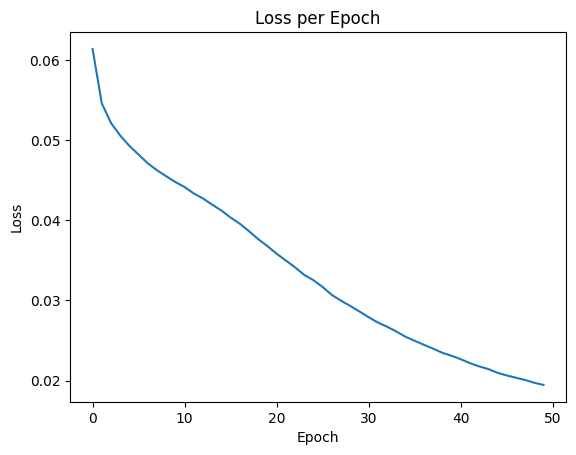

In [ ]:
plt.plot(loss_per_epoch)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.show()

Training done
##Model performance measurements

In [76]:
mainModel.load_state_dict(torch.load(r'/content/drive/MyDrive/Colab Notebooks/modelMain_WithTime_k_3_5wanted.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

In [77]:
# if(combined_test_chunked_data_tensor.shape):
#   dataset = GHIDataset(combined_test_chunked_data_tensor, device=device)
#   train_loader = DataLoader(dataset, batch_size=32, shuffle=True)
# dataset = GHIDataset(combined_chunked_data_tensor, device=device)
# train_loader = DataLoader(dataset, batch_size=32, shuffle=True)
mainModel.eval()
outputlist = []
targetData=[]
colourList = []
for inputs, targets in train_loader:
  output = mainModel(inputs)
  colourList.append(inputs[:,-1].detach().cpu().numpy())#Saving hour before predicted hour
  targetData.append(targets.detach().cpu().numpy())
  outputlist.append(output.detach().cpu().numpy())
colourList = np.concatenate(colourList[:-1], axis=0)#Last batch size is too small so getting rid of it with the -1
outputlist = np.concatenate(outputlist[:-1], axis=0)
targetData = np.concatenate(targetData[:-1], axis=0)
del combined_chunked_data_tensor #Saving RAM space

In [ ]:
#colourList.shape

In [ ]:
# for i, data in enumerate(train_loader):
#   print(data[0].shape)
#   print(data[1].shape)
#   print(data.shape)

In [ ]:
'''
Wanted:
Global horizontal irradiance / kJ/m2',
'Direct normal irradiance / kJ/m2',
'Diffuse horizontal irradiance / kJ/m2',
'Wind speed / 0.1 m/s',
'Hour_sin',
'Hour_cos',
'Month_sin',
'Month_cos',
'wind_dir_sin',
'wind_dir_cos',


Nearest*3:
Global horizontal irradiance / kJ/m2',
'Direct normal irradiance / kJ/m2',
'Diffuse horizontal irradiance / kJ/m2',
'Wind speed / 0.1 m/s',
'wind_dir_sin',
'wind_dir_cos',
'distanceX',
'distanceY
'''

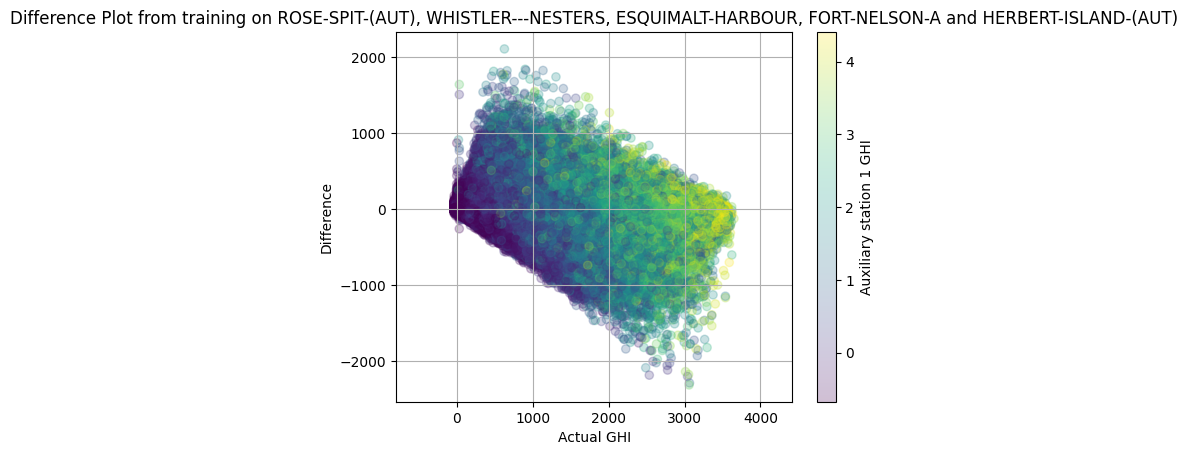

In [97]:
mean_MeansGHI = np.mean([meanGHI1, meanGHI2, meanGHI3, meanGHI4, meanGHI5])
std_MeansGHI = np.mean([stdGHI1, stdGHI2, stdGHI3, stdGHI4, stdGHI5])
targetGHI = targetData*std_MeansGHI + mean_MeansGHI
outputGHI = outputlist*std_MeansGHI + mean_MeansGHI #normalized
colourListGHI = colourList[:,0]*std_MeansGHI + mean_MeansGHI
# angle_rad = np.arcsin(colourList[:,:,6])# 4 For hours. Can also do 6 for months
# angle_deg = np.degrees(angle_rad)
# hour = (angle_deg + 90) * 24 / 180  # Map angle from [-90, 90] to [0, 24]
# month = (angle_deg + 90) * 12 / 180  # Map angle from [-90, 90] to [0, 12]
plt.scatter(targetGHI.flatten(), outputGHI.flatten()-targetGHI.flatten(), c=colourList[:,10].flatten(), alpha=0.25)
#plt.scatter(targetData.flatten(), outputlist.flatten()-targetData.flatten(), c=colourList[:,10].flatten(), alpha=0.25)
plt.axis('equal')
plt.colorbar(label="Auxiliary station 1 GHI")
plt.xlabel('Actual GHI')
plt.ylabel('Difference')
plt.title('Difference Plot from training on ROSE-SPIT-(AUT), WHISTLER---NESTERS, ESQUIMALT-HARBOUR, FORT-NELSON-A and HERBERT-ISLAND-(AUT)')
plt.grid()
plt.show()

In [99]:
ave = np.mean(np.abs(outputGHI.flatten()-targetGHI.flatten()))
print(ave)

66.87466028685185


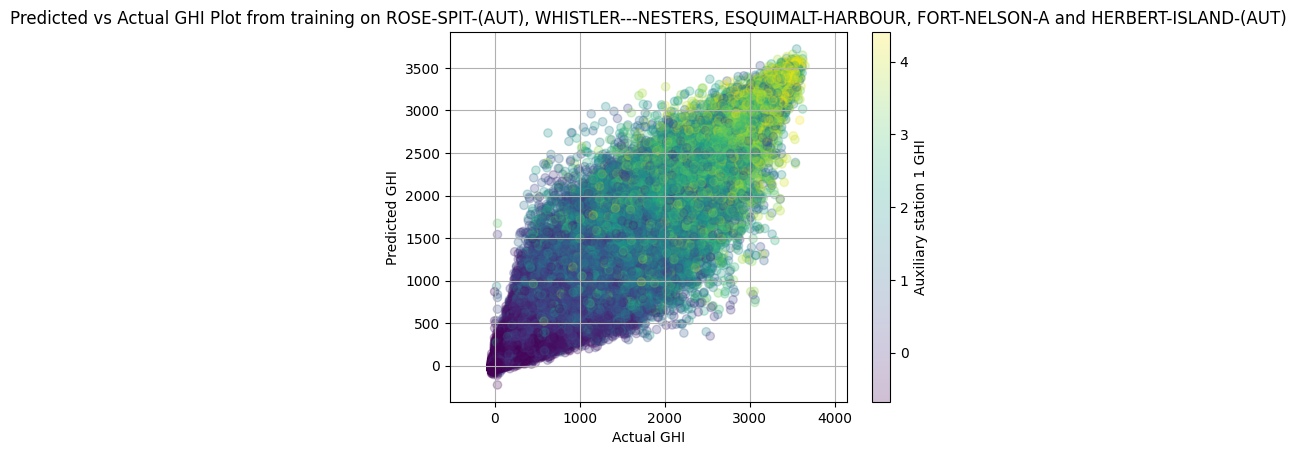

In [100]:
plt.scatter(targetGHI.flatten(), outputGHI.flatten(), c=colourList[:,10].flatten(), alpha=0.25)
#plt.scatter(targetData.flatten(), outputlist.flatten(), c=colourList[:,10].flatten(), alpha=0.25)
plt.axis('equal')
plt.colorbar(label="Auxiliary station 1 GHI")
plt.xlabel('Actual GHI')
plt.ylabel('Predicted GHI')
plt.title('Predicted vs Actual GHI Plot from training on ROSE-SPIT-(AUT), WHISTLER---NESTERS, ESQUIMALT-HARBOUR, FORT-NELSON-A and HERBERT-ISLAND-(AUT)')
plt.grid()
plt.show()

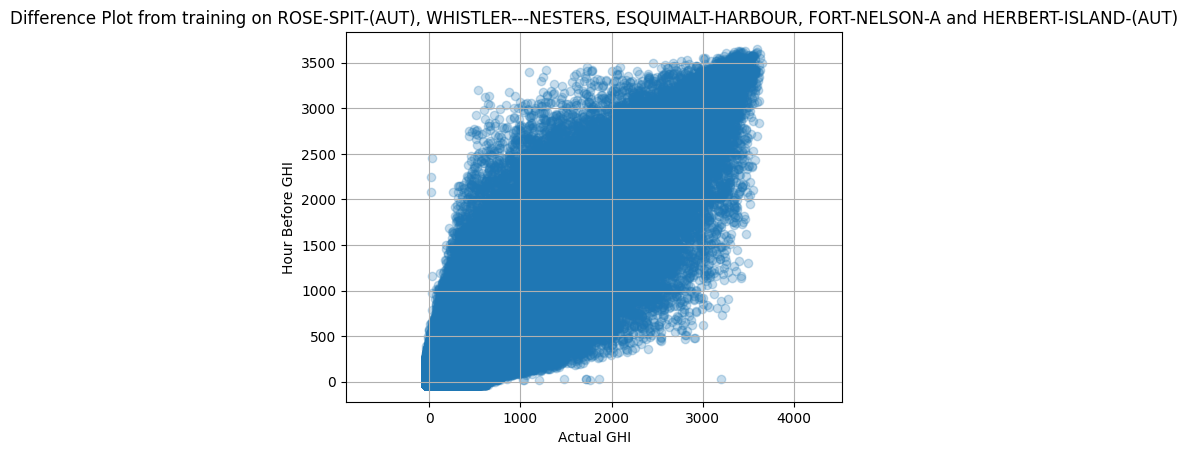

In [101]:
plt.scatter(targetGHI.flatten(), colourListGHI.flatten(), alpha=0.25)
#plt.scatter(targetData.flatten(), colourList[:,0].flatten(), alpha=0.25)
plt.axis('equal')
#plt.colorbar(label="inputFeature GHI")
plt.xlabel('Actual GHI')
plt.ylabel('Hour Before GHI')
plt.title('Difference Plot from training on ROSE-SPIT-(AUT), WHISTLER---NESTERS, ESQUIMALT-HARBOUR, FORT-NELSON-A and HERBERT-ISLAND-(AUT)')
plt.grid()
plt.show()

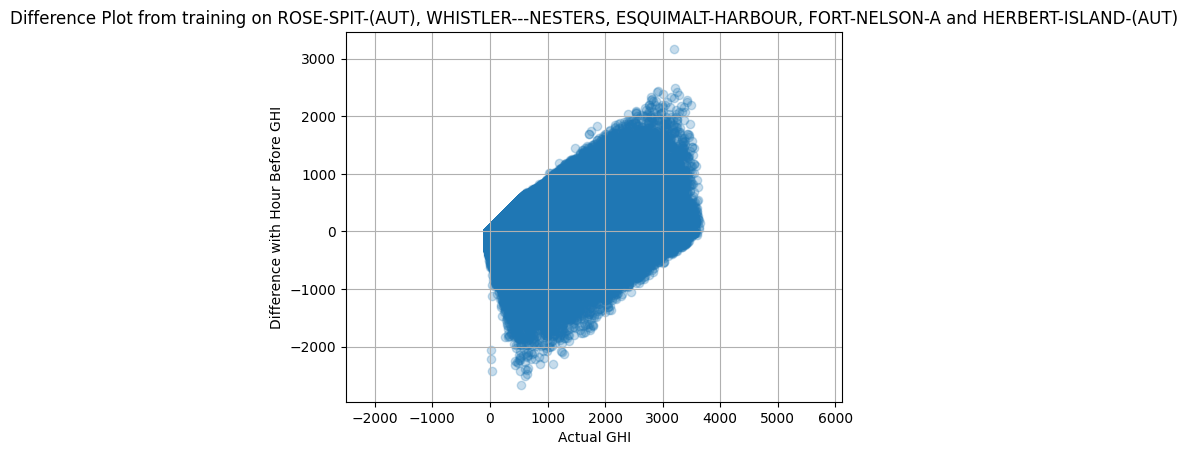

In [102]:
plt.scatter(targetGHI.flatten(), targetGHI.flatten()-colourListGHI.flatten(), alpha=0.25)
#plt.scatter(targetData.flatten(), targetData.flatten()-colourList[:,0].flatten(), alpha=0.25)
plt.axis('equal')
#plt.colorbar(label="inputFeature GHI")
plt.xlabel('Actual GHI')
plt.ylabel('Difference with Hour Before GHI')
plt.title('Difference Plot from training on ROSE-SPIT-(AUT), WHISTLER---NESTERS, ESQUIMALT-HARBOUR, FORT-NELSON-A and HERBERT-ISLAND-(AUT)')
plt.grid()
plt.show()

In [103]:
ave = np.mean(np.abs(targetGHI.flatten()-colourListGHI.flatten()))
print(ave)

144.61109610694953


In [105]:
LRmodel = LinearRegression()
LRmodel.fit(colourList[:,0].reshape(-1,1), targetData)
r_sq = LRmodel.score(colourList[:,0].reshape(-1,1), targetData) # Coefficient of determination
print(f"coefficient of determination: {r_sq}")
print(f"intercept: {LRmodel.intercept_}")
print(f"coefficients: {LRmodel.coef_}")

y_pred = LRmodel.predict(colourList[:,0].reshape(-1,1))
print(f"predicted response:\n{y_pred}")
y_pred_GHI = y_pred*std_MeansGHI + mean_MeansGHI

coefficient of determination: 0.868524432182312
intercept: 6.4247287809848785e-06
coefficients: [0.93194586]
predicted response:
[ 1.3547798   3.0057197  -0.60186225 ... -0.5847535  -0.5415115
 -0.6290363 ]


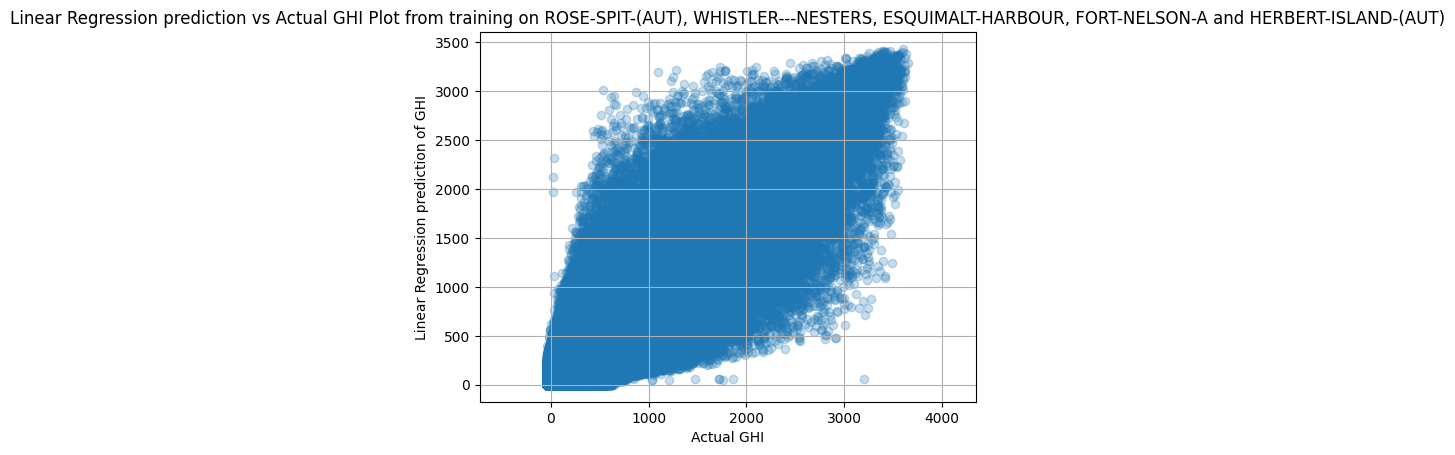

In [106]:
plt.scatter(targetGHI.flatten(), y_pred_GHI.flatten(), alpha=0.25)
#plt.scatter(targetData.flatten(), y_pred.flatten(), alpha=0.25)
plt.axis('equal')
#plt.colorbar(label="inputFeature GHI")
plt.xlabel('Actual GHI')
plt.ylabel('Linear Regression prediction of GHI')
plt.title('Linear Regression prediction vs Actual GHI Plot from training on ROSE-SPIT-(AUT), WHISTLER---NESTERS, ESQUIMALT-HARBOUR, FORT-NELSON-A and HERBERT-ISLAND-(AUT)')
plt.grid()
plt.show()

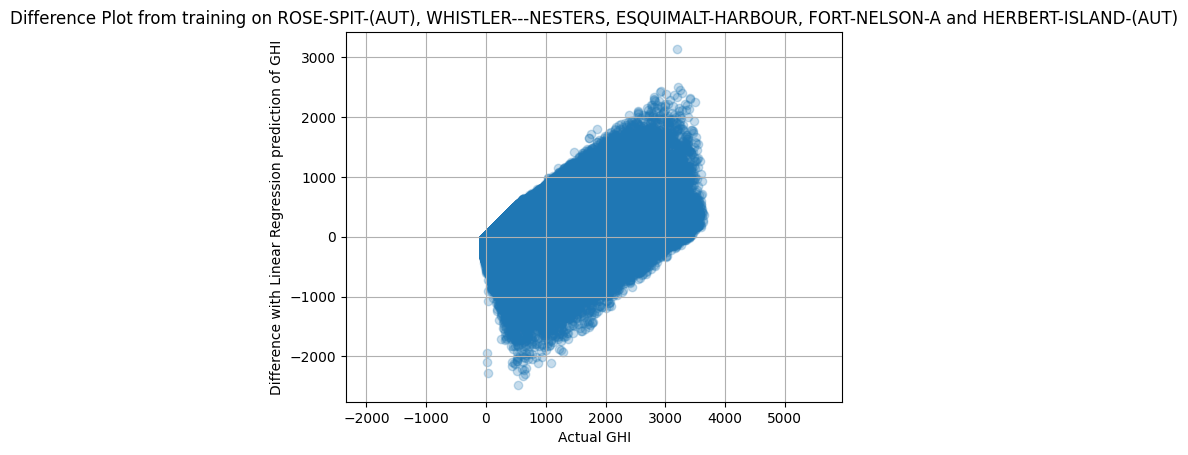

In [107]:
plt.scatter(targetGHI.flatten(), targetGHI.flatten()-y_pred_GHI.flatten(), alpha=0.25)
#plt.scatter(targetData.flatten(), targetData.flatten()-y_pred.flatten(), alpha=0.25)
plt.axis('equal')
#plt.colorbar(label="inputFeature GHI")
plt.xlabel('Actual GHI')
plt.ylabel('Difference with Linear Regression prediction of GHI')
plt.title('Difference Plot from training on ROSE-SPIT-(AUT), WHISTLER---NESTERS, ESQUIMALT-HARBOUR, FORT-NELSON-A and HERBERT-ISLAND-(AUT)')
plt.grid()
plt.show()

In [108]:
ave = np.mean(np.abs(targetGHI.flatten()-y_pred_GHI.flatten()))
print(ave)

155.33675946955145


Performance eval done
##Analyzing data and testing

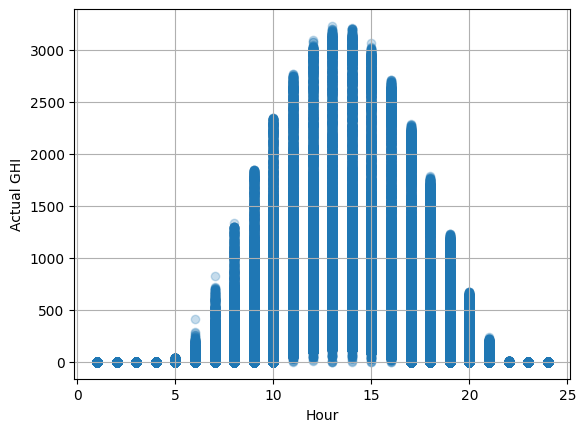

1.0


In [ ]:
angle = np.arctan2(colourList[:,4], colourList[:,5])# 4(sin), 5(cos) For hours. Can also do 6(sin), 7(cos) for months
hour = (angle / (2 * np.pi)) * 24 + 1
hour = hour % 24 + 1
month =(angle / (2 * np.pi)) * 12 + 1
month = month % 12 + 1
GHIActual = targetData*stdGHI1 + meanGHI1
plt.scatter(hour, GHIActual, alpha=0.25)#Trying to plot hours versus GHI
plt.axis('tight')
#plt.colorbar(label="inputFeature GHI")
plt.xlabel('Hour')
plt.ylabel('Actual GHI')
plt.title('')
plt.grid()
plt.show()
print(hour.min())

In [ ]:
np.unique(colourList[:,4])

array([-1.0000000e+00, -9.6592581e-01, -8.6602539e-01, -7.0710677e-01,
       -5.0000000e-01, -2.5881904e-01,  0.0000000e+00,  1.2246469e-16,
        2.5881904e-01,  5.0000000e-01,  7.0710677e-01,  8.6602539e-01,
        9.6592581e-01,  1.0000000e+00], dtype=float32)

In [ ]:
np.unique(colourList[:,5])

array([-1.0000000e+00, -9.6592581e-01, -8.6602539e-01, -7.0710677e-01,
       -5.0000000e-01, -2.5881904e-01, -1.8369701e-16,  6.1232343e-17,
        2.5881904e-01,  5.0000000e-01,  7.0710677e-01,  8.6602539e-01,
        9.6592581e-01,  1.0000000e+00], dtype=float32)

In [ ]:
hour[0:50]

array([18., 18., 21., 20., 12.,  0., 23.,  7., 12., 19., 22.,  2.,  8.,
        4., 20.,  9., 16.,  3., 11., 15., 14.,  0., 21.,  6., 23., 12.,
       21.,  7.,  7., 12., 14., 11.,  5., 18., 13., 21.,  3., 17.,  3.,
        8., 12.,  5.,  6., 15., 10.,  4.,  8., 15., 17., 22.],
      dtype=float32)

In [ ]:
np.unique((colourList[:,4]))

array([-1.0000000e+00, -9.6592581e-01, -8.6602539e-01, -7.0710677e-01,
       -5.0000000e-01, -2.5881904e-01,  0.0000000e+00,  1.2246469e-16,
        2.5881904e-01,  5.0000000e-01,  7.0710677e-01,  8.6602539e-01,
        9.6592581e-01,  1.0000000e+00], dtype=float32)

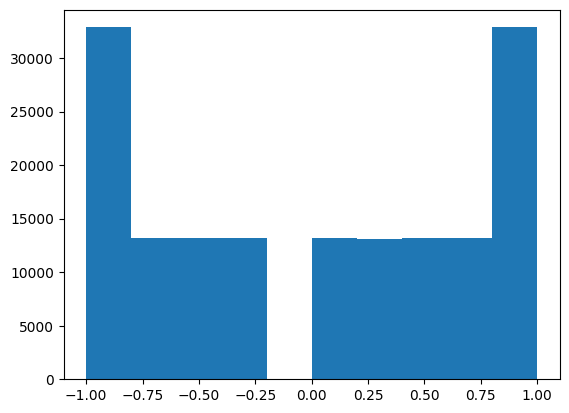

In [ ]:
plt.hist(colourList[:,4]);

In [ ]:
def get_nearest_stations_data(nearest_stations_csvs, min_start_year, max_end_year, wantedStationCSV=False, RelativeAnglesDegrees=[(0,0)]):
    dfs = []
    i = 0
    meanGHI = 0
    stdGHI = 0
    for f in nearest_stations_csvs:
      # Read the CSV file with specified columns and data types
      df = pd.read_csv(f, delimiter=',', skiprows=2, index_col=False, usecols=usecols, dtype=dtype, on_bad_lines='skip')
      # Convert columns to numeric, coercing errors to NaN
      for col in usecols:
          if(col == 'Year Month Day Hour (YYYYMMDDHH)'):
              #keep as string
              df['Year Month Day Hour (YYYYMMDDHH)'] = df[col].astype(int)
              df = df[df['Year Month Day Hour (YYYYMMDDHH)']>min_start_year]
              df = df[df['Year Month Day Hour (YYYYMMDDHH)']<=max_end_year]#Data is between min_start_year and max_end_year to accomidate files that dont have the same amount of data

              if(wantedStationCSV): #get month and hour for just wanted station
                  df['Year Month Day Hour (YYYYMMDDHH)'] = df['Year Month Day Hour (YYYYMMDDHH)'].astype(str)
                  # Get month (1-12)
                  df['Month'] = df['Year Month Day Hour (YYYYMMDDHH)'].str[4:6].astype(int)
                  # Get hour (1-24)
                  df['Hour'] = df['Year Month Day Hour (YYYYMMDDHH)'].str[8:10].astype(int)
                  # Normalize hour so cyclic (0-23)
                  df['Hour_sin'] = np.sin(2 * np.pi * (df['Hour'] - 1) / 24)  # Sine encoding for hours (adjust for 0-23)
                  df['Hour_cos'] = np.cos(2 * np.pi * (df['Hour'] - 1) / 24)  # Cosine encoding for hours (adjust for 0-23)
                  # Normalize month so cyclic (0-11))
                  df['Month_sin'] = np.sin(2 * np.pi *  (df['Month']-1)/ 12)  # Sine encoding for months
                  df['Month_cos'] = np.cos(2 * np.pi *  (df['Month']-1) / 12)  # Cosine encoding for months

              df = df.drop(columns=[col], axis=1)
              continue

          if(col=='Wind direction / 0-359 degrees'):
              df[col] = pd.to_numeric(df[col], errors='coerce').replace(99, np.nan)
              if(not wantedStationCSV):
                df[col] = df[col].apply(lambda x: adjustWindDirection(x, RelativeAnglesDegrees[i]))
                #When wind is pointed towards the wanted station it has a new angle of 0 degrees and when pointed directly away from it it has a 180 degrees value now
              radians = np.deg2rad(df[col])
              df['wind_dir_sin'] = np.sin(radians)
              df['wind_dir_cos'] = np.cos(radians)
              df = df.drop(columns=[col], axis=1)
              continue

          if(col == 'Wind speed / 0.1 m/s'):
              df[col] = pd.to_numeric(df[col], errors='coerce').replace(99, np.nan)
              mean = df[col].mean()
              std = df[col].std()
              df[col] = (df[col] - mean) / std
              continue

          if (col == 'Global horizontal irradiance / kJ/m2' or col == 'Direct normal irradiance / kJ/m2' or col == 'Diffuse horizontal irradiance / kJ/m2'):
              df[col] = pd.to_numeric(df[col], errors='coerce').replace(9999, np.nan)
              mean = df[col].mean()
              std = df[col].std()
              df[col] = (df[col] - mean) / std #can denormalize output
              if (col == 'Global horizontal irradiance / kJ/m2'):
                meanGHI = mean
                stdGHI = std #for denormalizing
              continue
          df[col] = pd.to_numeric(df[col], errors='coerce')
      df.fillna(0, inplace=True)
      dfs.append(df)
      i+=1
      #print(df.columns)
    return dfs, meanGHI, stdGHI

In [ ]:
def getAllKAuxillaryStationsReadyByWantedStationNameTEST(stationsName_lat_long_datadf, nearest_stations, k, min_start_year, max_end_year, RelativeAnglesDegrees):
  #doing all thats needed to get Auxillary stations data ready and in chunked tensors and in order chunked
  modified_nearest_stations = modify_nearest_stations(nearest_stations)
  nearest_stations_csvs, station_order = find_stations_csv(modified_nearest_stations, csv_files)
  nearest_stations_data_dfs, _, _ = get_nearest_stations_data(nearest_stations_csvs, min_start_year, max_end_year, False, RelativeAnglesDegrees)

  for i in range(k):
    nearest_stations_data_dfs[i]["distanceX"] = [nearest_stations['distance'].values[i][1][0]]*len(nearest_stations_data_dfs[i])
    nearest_stations_data_dfs[i]["distanceY"] = [nearest_stations['distance'].values[i][1][1]]*len(nearest_stations_data_dfs[i])
    #print(nearest_stations_data_dfs[i].head())
    #print(nearest_stations_data_dfs[i].columns)
  return nearest_stations_data_dfs

In [ ]:
def getAllReadyForStationByLatAndLongAndKTEST(stationsName_lat_long_datadf, lat, long, k):
  wanted_station = find_nearest_station_given_long_lat(stationsName_lat_long_datadf, lat, long)
  max_start_year = wanted_station["StartTime"].values[0]
  min_end_year = wanted_station["EndTime"].values[0]

  wanted_station.at[wanted_station.index[0], "distance"] = (0.0, (0.0, 0.0))
  wanted_station_modified = modify_nearest_stations({"station": wanted_station["station"]})
  wanted_station_csv, _ = find_stations_csv(wanted_station_modified, csv_files)

  nearest_stations, target_point = spatially_diverse_knn(stationsName_lat_long_datadf, wanted_station["station"].values[0], k)
  plot_stations_matplotlib(target_point, nearest_stations, stationsName_lat_long_datadf)
  max_start_year, min_end_year = max(max_start_year, *nearest_stations["StartTime"].values), min(min_end_year, *nearest_stations["EndTime"].values)
  max_start_year, min_end_year = getMaxStartMinEndYearComplete(max_start_year, min_end_year)

  RelativeAnglesDegrees = []
  for distanceVector in nearest_stations["distance"].values:
    Relative_Angle_Radians = np.arctan2(distanceVector[1][1], distanceVector[1][0])#Relative Distance Vector y and Distance Vector x
    Relative_Angle_Degrees = np.degrees(Relative_Angle_Radians)
    if Relative_Angle_Degrees < 0:
      Relative_Angle_Degrees += 360
    RelativeAnglesDegrees.append(Relative_Angle_Degrees)

  nearest_stations_data_dfs = getAllKAuxillaryStationsReadyByWantedStationNameTEST(stationsName_lat_long_datadf, nearest_stations, k, max_start_year, min_end_year, RelativeAnglesDegrees)

  wanted_station_data_dfs, mean, std = get_nearest_stations_data(wanted_station_csv, max_start_year, min_end_year,wantedStationCSV=True)
  #print(wanted_station_data_dfs[0].head())
  #wanted_chunked_tensors, _ = get_chunked_tensors(wanted_station, wanted_station_data_dfs, 25)

  return wanted_station_data_dfs, wanted_station["station"].values[0], nearest_stations_data_dfs, mean, std

Station ROSE-SPIT-(AUT) found in /content/drive/MyDrive/Colab Notebooks/CWEEDS_2020_BC/CAN_BC_ROSE-SPIT-(AUT)_1056869_CWEEDS2011_1998-2017.csv


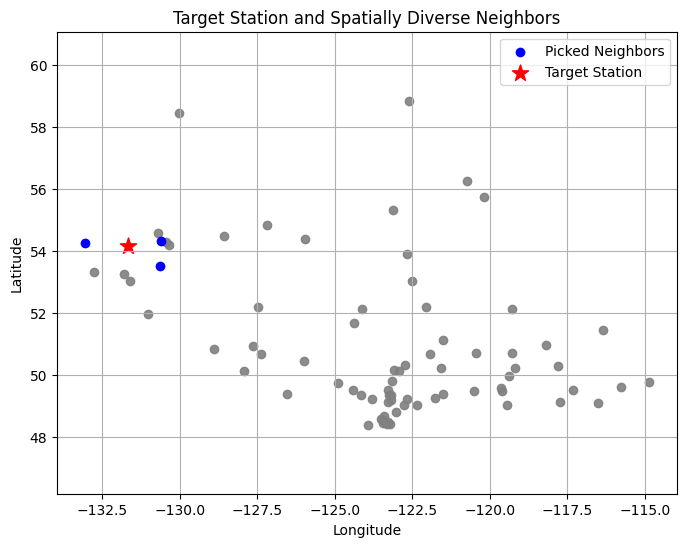

Station LUCY-ISLAND-LIGHTSTATION found in /content/drive/MyDrive/Colab Notebooks/CWEEDS_2020_BC/CAN_BC_LUCY-ISLAND-LIGHTSTATION_1064728_CWEEDS2011_1999-2017.csv
Station LANGARA-ISLAND-RCS found in /content/drive/MyDrive/Colab Notebooks/CWEEDS_2020_BC/CAN_BC_LANGARA-ISLAND-RCS_1054503_CWEEDS2011_1998-2016.csv
Station BONILLA-ISLAND-(AUT) found in /content/drive/MyDrive/Colab Notebooks/CWEEDS_2020_BC/CAN_BC_BONILLA-ISLAND-(AUT)_1060R0K_CWEEDS2011_1998-2017.csv


In [ ]:
wanted_station_data_dfs, wanted_station_name, nearest_stations_data_dfs, mean, std = getAllReadyForStationByLatAndLongAndKTEST(stationsName_lat_long_datadf.copy(), -131.75, 54.5, 3)

In [ ]:
wanted_station_data_dfs[0].iloc[0:25]

,Global horizontal irradiance / kJ/m2,Direct normal irradiance / kJ/m2,Diffuse horizontal irradiance / kJ/m2,Wind speed / 0.1 m/s,Month,Hour,Hour_sin,Hour_cos,Month_sin,Month_cos,wind_dir_sin,wind_dir_cos
8760,-0.581062,-0.417948,-0.662343,-1.146427,1,1,0.000000e+00,1.000000e+00,0.0,1.0,1.224647e-16,-1.000000
8761,-0.581062,-0.417948,-0.662343,-1.011795,1,2,2.588190e-01,9.659258e-01,0.0,1.0,1.224647e-16,-1.000000
8762,-0.581062,-0.417948,-0.662343,-1.146427,1,3,5.000000e-01,8.660254e-01,0.0,1.0,1.736482e-01,-0.984808
8763,-0.581062,-0.417948,-0.662343,-0.450830,1,4,7.071068e-01,7.071068e-01,0.0,1.0,6.427876e-01,-0.766044
8764,-0.581062,-0.417948,-0.662343,0.356961,1,5,8.660254e-01,5.000000e-01,0.0,1.0,5.000000e-01,-0.866025
8765,-0.581062,-0.417948,-0.662343,1.030120,1,6,9.659258e-01,2.588190e-01,0.0,1.0,6.427876e-01,-0.766044
8766,-0.581062,-0.417948,-0.662343,0.850611,1,7,1.000000e+00,6.123234e-17,0.0,1.0,6.427876e-01,-0.766044
8767,-0.581062,-0.417948,-0.662343,1.411576,1,8,9.659258e-01,-2.588190e-01,0.0,1.0,6.427876e-01,-0.766044
8768,-0.581062,-0.417948,-0.662343,0.962804,1,9,8.660254e-01,-5.000000e-01,0.0,1.0,6.427876e-01,-0.766044
8769,-0.581062,-0.417948,-0.662343,1.164752,1,10,7.071068e-01,-7.071068e-01,0.0,1.0,6.427876e-01,-0.766044


In [ ]:
nearest_stations_data_dfs[0].head()

,Global horizontal irradiance / kJ/m2,Direct normal irradiance / kJ/m2,Diffuse horizontal irradiance / kJ/m2,Wind speed / 0.1 m/s,wind_dir_sin,wind_dir_cos,distanceX,distanceY
0,-0.578652,-0.414028,-0.659494,0.596278,-0.568188,0.822899,-8503.660762,6037.884517
1,-0.578652,-0.414028,-0.659494,0.701851,-0.568188,0.822899,-8503.660762,6037.884517
2,-0.578652,-0.414028,-0.659494,0.828539,-0.568188,0.822899,-8503.660762,6037.884517
3,-0.578652,-0.414028,-0.659494,0.828539,-0.568188,0.822899,-8503.660762,6037.884517
4,-0.578652,-0.414028,-0.659494,0.934112,-0.568188,0.822899,-8503.660762,6037.884517


In [ ]:
def denormalizeHourOrMonth(anglesin, anglecos, cycleLength):
  angle = np.arctan2(anglesin, anglecos)
  cycleBeforeModulo = (angle / (2 * np.pi)) * cycleLength + 1
  return (cycleBeforeModulo % cycleLength)

In [ ]:
def cyclicalEncoding(data, cycleLength):
  newDatasin = np.sin(2 * np.pi * (data - 1) / cycleLength)  # Sine encoding for hours (adjust for 0-23)
  newDatacos = np.cos(2 * np.pi * (data - 1) / cycleLength)  # Cosine encoding for hours (adjust for 0-23)
  return newDatasin, newDatacos

<ipython-input-198-2fa038852f8b>:2: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  newDatasin = np.sin(2 * np.pi * (data - 1) / cycleLength)  # Sine encoding for hours (adjust for 0-23)
<ipython-input-198-2fa038852f8b>:3: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  newDatacos = np.cos(2 * np.pi * (data - 1) / cycleLength)  # Cosine encoding for hours (adjust for 0-23)


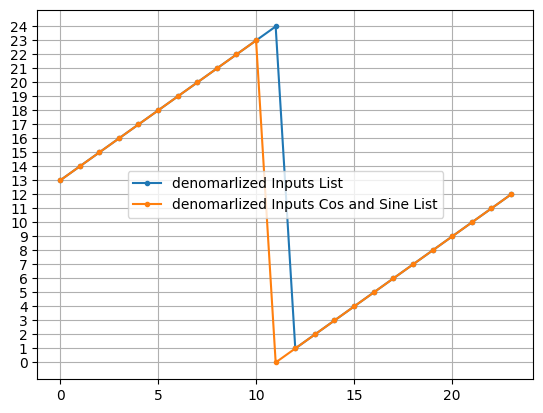

tensor([-8.7423e-08, -2.5882e-01, -5.0000e-01, -7.0711e-01, -8.6603e-01,
        -9.6593e-01, -1.0000e+00, -9.6593e-01, -8.6603e-01, -7.0711e-01,
        -5.0000e-01, -2.5882e-01,  0.0000e+00,  2.5882e-01,  5.0000e-01,
         7.0711e-01,  8.6603e-01,  9.6593e-01,  1.0000e+00,  9.6593e-01,
         8.6603e-01,  7.0711e-01,  5.0000e-01,  2.5882e-01])
tensor([ 1.2246e-16, -2.5882e-01, -5.0000e-01, -7.0711e-01, -8.6603e-01,
        -9.6593e-01, -1.0000e+00, -9.6593e-01, -8.6603e-01, -7.0711e-01,
        -5.0000e-01, -2.5882e-01,  0.0000e+00,  2.5882e-01,  5.0000e-01,
         7.0711e-01,  8.6603e-01,  9.6593e-01,  1.0000e+00,  9.6593e-01,
         8.6603e-01,  7.0711e-01,  5.0000e-01,  2.5882e-01])


In [ ]:
# angle = np.arctan2(newDatasin,newDatacos)
# hour = (angle / (2 * np.pi)) * 24 + 1
# hour = hour % 24
# hour
# plt.plot(np.unique(hour))
# funcHour = denormalizeHourOrMonth(newDatasin,newDatacos, 24)
# plt.plot(np.unique(funcHour))
idx = 2
inputsin, inputcos = cyclicalEncoding(inputs[idx,:,5],24)#inputs moved by 2 here as used to have hour and month still in dfs
inputsin = inputsin.to(torch.float32)
inputcos = inputcos.to(torch.float32)
funcolourHour = denormalizeHourOrMonth(inputsin, inputcos, 24)
plt.plot(funcolourHour, label="denomarlized Inputs List", marker='.')
funcolourHour = denormalizeHourOrMonth(inputs[idx,:,6], inputs[idx,:,7], 24)
plt.plot(funcolourHour, label="denomarlized Inputs Cos and Sine List", marker='.')
#plt.plot(inputs[idx,:,5], label="Inputs real", marker='.')
plt.legend()
plt.grid()
plt.yticks(np.arange(0,25,1))
plt.show()
print(inputsin)
print(inputs[idx,:,6] )  #MODULUS ISSUE SHOWING THEY ARE EQUIVALENT! Just a floating point number problem
#First one of inputsin is negative and first one of inputs[idx,:,6] is slightly positive so goes in opposite direction when arctaned
#This results in the hours being off by 1 when DENORMALIZED
# print(inputcos)
# print(inputs[idx,:,7])

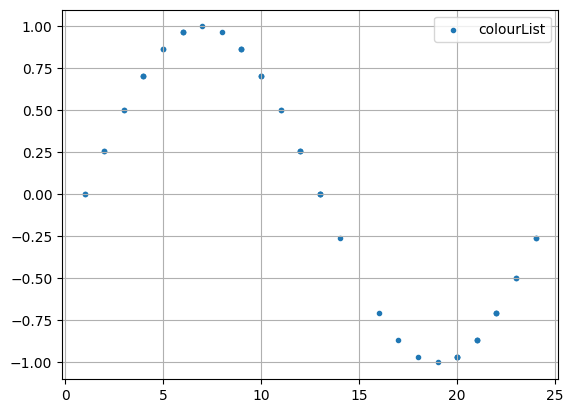

In [ ]:
funcolourHour = denormalizeHourOrMonth(colourList[:,6], colourList[:,7], 24)
#plt.scatter(funcolourHour[0:50],colourList[0:50,6], label="denomarlized Colour List", marker='.')
plt.scatter(colourList[0:50,5],colourList[0:50,6], label="colourList", marker='.')
plt.legend()
plt.grid()

plt.show()